In [ ]:
!unzip dontpatronizeme_v1.4.zip
!cp /content/dontpatronizeme_v1.4/* .

Archive:  dontpatronizeme_v1.4.zip
   creating: dontpatronizeme_v1.4/
  inflating: dontpatronizeme_v1.4/README.txt  
  inflating: dontpatronizeme_v1.4/dontpatronizeme_categories.tsv  
  inflating: dontpatronizeme_v1.4/dontpatronizeme_pcl.tsv  


# Main imports and code

In [ ]:
# check which gpu we're using
!nvidia-smi

Sun Jan 23 15:55:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install simpletransformers
!pip install tensorboardx

In [ ]:
# !pip install pandas --upgrade
!pip install pandas==1.2.2

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval
import os

In [ ]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [ ]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


2022-01-23 15:56:04.243693: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


# Fetch Don't Patronize Me! data manager module

In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [ ]:
from dont_patronize_me import DontPatronizeMe

In [ ]:
dpm = DontPatronizeMe('.', '.')

In [ ]:
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


In [ ]:
import pandas as pd
pd.__version__

'1.2.2'

# Load paragraph IDs

In [ ]:
!wget https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv
!wget https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv

--2022-01-23 15:56:04--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61151 (60K) [text/plain]
Saving to: ‘dev_semeval_parids-labels.csv’

dev_semeval_parids- 100%[===================>]  59.72K  --.-KB/s    in 0.01s   

2022-01-23 15:56:05 (4.31 MB/s) - ‘dev_semeval_parids-labels.csv’ saved [61151/61151]

--2022-01-23 15:56:05--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com

In [ ]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [ ]:
trids.head()

,par_id,label
0,4341,"[1, 0, 0, 1, 0, 0, 0]"
1,4136,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,"[1, 0, 0, 1, 1, 1, 0]"


In [ ]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

# Rebuild training set (Task 2 unb)

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  label = trids.label[idx]
  # select row from original dataset to retrieve the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  rows2.append({
      'par_id':parid,
      'keyword':keyword,
      'country':country,
      'text':text,
      'label':label
  })
  

In [ ]:
# rows = [] # will contain par_id, label and text
# for idx in range(len(trids)):  
#   parid = trids.par_id[idx]
#   #print(parid)
#   # select row from original dataset to retrieve `text` and binary label
#   text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
#   label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
#   keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
#   country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
#   rows.append({
#       'par_id':parid,
#       'keyword':keyword,
#       'country':country,
#       'text':text,
#       'label':label
#   })
  

In [ ]:
trdf1 = pd.DataFrame(rows2)

In [ ]:
# trdf1 = trdf1[trdf1.label != '[0, 0, 0, 0, 0, 0, 0]']

In [ ]:
r = []
for i in range(len(trdf1)):
 r.append(int(trdf1.label[i][10]))

trdf1['label'] = r

In [ ]:
trdf1.head()

,par_id,keyword,country,text,label
0,4341,poor-families,gb,"the scheme saw an estimated 150,000 children f...",1
1,4136,homeless,za,durban 's homeless communities reconciliation ...,0
2,10352,poor-families,lk,the next immediate problem that cropped up was...,0
3,8279,vulnerable,nz,far more important than the implications for t...,1
4,1164,poor-families,gh,to strengthen child-sensitive social protectio...,1


In [ ]:
!pip install pycountry

  Using cached pycountry-22.1.10.tar.gz (10.1 MB)
  Created wheel for pycountry: filename=pycountry-22.1.10-py2.py3-none-any.whl size=10595784 sha256=e2fa5eb4ef4967b459dd41b835802fb0fcf2240b1b72eec95a6082361f453e90
  Stored in directory: /root/.cache/pip/wheels/f7/8f/9c/b070d7376caf2beb0685bf72578106b2fd57019ed57d84f126
Successfully built pycountry


In [ ]:
import pycountry
import pycountry

list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)]
list_alpha_3 = [i.alpha_3 for i in list(pycountry.countries)]    

def country_flag(df):
    # print(df[2])
    if (len(df['country'])==2 and df['country'].upper() in list_alpha_2):
        return pycountry.countries.get(alpha_2=df['country'].upper()).name
    elif (len(df['country'])==3 and df['country'].upper() in list_alpha_3):
        return pycountry.countries.get(alpha_3=df['country'].upper()).name
    else:
        return df['country']

In [ ]:
trdf1['country']=trdf1.apply(country_flag, axis = 1)
trdf1.head()

,par_id,keyword,country,text,label
0,4341,poor-families,United Kingdom,"the scheme saw an estimated 150,000 children f...",1
1,4136,homeless,South Africa,durban 's homeless communities reconciliation ...,0
2,10352,poor-families,Sri Lanka,the next immediate problem that cropped up was...,0
3,8279,vulnerable,New Zealand,far more important than the implications for t...,1
4,1164,poor-families,Ghana,to strengthen child-sensitive social protectio...,1


# Rebuild test set (Task 1)

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  label = teids.label[idx]
  #print(parid)
  # select row from original dataset to access the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  rows2.append({
      'par_id':parid,
      'keyword':keyword,
      'country':country,
      'text':text,
      'label':label
  })
  

In [ ]:
# rows = [] # will contain par_id, label and text
# for idx in range(len(teids)):  
#   parid = teids.par_id[idx]
#   #print(parid)
#   # select row from original dataset
#   text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
#   label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
#   keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
#   country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
#   rows.append({
#       'par_id':parid,
#       'keyword':keyword,
#       'country':country,
#       'text':text,
#       'label':label
#   })
  

In [ ]:
len(rows2)

2094

In [ ]:
tedf1 = pd.DataFrame(rows2)

In [ ]:
tedf1.head()

,par_id,keyword,country,text,label
0,4046,hopeless,us,we also know that they can benefit by receivin...,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,refugee,ng,pope francis washed and kissed the feet of mus...,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,refugee,ng,many refugees do n't want to be resettled anyw...,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,in-need,ie,"""budding chefs , like """" fred """" , """" winston ...","[1, 0, 0, 1, 1, 1, 0]"
4,4089,homeless,pk,"""in a 90-degree view of his constituency , one...","[1, 0, 0, 0, 0, 0, 0]"


In [ ]:
r = []
for i in range(len(tedf1)):
 r.append(int(tedf1.label[i][10]))

tedf1['label'] = r

In [ ]:
tedf1['country']=tedf1.apply(country_flag, axis = 1)
tedf1.head()

,par_id,keyword,country,text,label
0,4046,hopeless,United States,we also know that they can benefit by receivin...,1
1,1279,refugee,Nigeria,pope francis washed and kissed the feet of mus...,0
2,8330,refugee,Nigeria,many refugees do n't want to be resettled anyw...,0
3,4063,in-need,Ireland,"""budding chefs , like """" fred """" , """" winston ...",1
4,4089,homeless,Pakistan,"""in a 90-degree view of his constituency , one...",0


# output train and test

In [ ]:
trdf1.to_csv('train_merr.csv', index=False)

# augment

In [ ]:
!pip install textaugment

     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 1.3 MB 8.0 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 65 kB 4.0 MB/s 
     |████████████████████████████████| 53 kB 2.5 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15735 sha256=c141b81ac567127108d36c5410f1d1e0e9435f36b2d2e1d8f6a44caca5dc6251
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans


In [ ]:
from textaugment import Word2vec
import gensim.downloader as api
model = api.load('glove-twitter-25') 
t = Word2vec(model=model)

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English
INFO:gensim.api:Creating /root/gensim-data


[==================================================] 100.0% 104.8/104.8MB downloaded


INFO:gensim.api:glove-twitter-25 downloaded
INFO:gensim.models.utils_any2vec:loading projection weights from /root/gensim-data/glove-twitter-25/glove-twitter-25.gz
INFO:gensim.models.utils_any2vec:loaded (1193514, 25) matrix from /root/gensim-data/glove-twitter-25/glove-twitter-25.gz


In [ ]:
%%time
line = "The extremes include unreconstructed Communists who never broke with Moscow , the neo-Nazi Golden Dawn that wants to mine the Turkish border again to keep immigrants out , and the misleadingly named Greek Ecologists , who are pro-nudism ."
t = Word2vec(model=model)
t.augment(line)

INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors


CPU times: user 1.02 s, sys: 240 ms, total: 1.26 s
Wall time: 733 ms


'every extremes include unreconstructed communists knows could gone my moscow , our neo-nazi crown episode does must take its the turkey police soon to keep citizens out , and the misleadingly named greek ecologists , who are pro-nudism .'

In [ ]:
from textaugment import EDA
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
t2 = EDA()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
!pip install numpy requests nlpaug

     |████████████████████████████████| 410 kB 4.3 MB/s 


In [ ]:
!pip install torch>=1.6.0 transformers>=4.0.0 sentencepiece

In [ ]:
%%time
import nlpaug.augmenter.sentence as nas

text = 'The quick brown fox jumps over the lazy dog . The quick brown boy jumps over the lazy dog'
aug = nas.ContextualWordEmbsForSentenceAug(model_path='gpt2')
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Original:
The quick brown fox jumps over the lazy dog . The quick brown boy jumps over the lazy dog
Augmented Text:
The quick brown fox jumps over the lazy dog . The quick brown boy jumps over the lazy dog new one all 's way .
CPU times: user 17.7 s, sys: 3.7 s, total: 21.4 s
Wall time: 25.7 s


In [ ]:
# import re
# tsv = open('/content/dontpatronizeme_v1.4/dontpatronizeme_categories.tsv', 'r')
# fileContent =  tsv.read()
# fileContent = re.sub("""(?ism)(,|"|')""", r"\\\1", fileContent) # escape all especial charaters (" ' ,) rfc4180
# fileContent = re.sub("\,", " ", fileContent)
# fileContent = re.sub("\t", ",", fileContent) # convert from tab to comma
# csv_file = open("/content/dontpatronizeme_v1.4/dontpatronizeme_categories.csv", "w")
# csv_file.write(fileContent)
# csv_file.close()

In [ ]:
# def country_flag(df):
#     # print(df[2])
#     if (len(df[4])==2 and df[4].upper() in list_alpha_2):
#         return pycountry.countries.get(alpha_2=df[4].upper()).name
#     elif (len(df[4])==3 and df[4].upper() in list_alpha_3):
#         return pycountry.countries.get(alpha_3=df[4].upper()).name
#     else:
#         return df[4]

In [ ]:
# task2 = pd.read_csv('/content/dontpatronizeme_v1.4/dontpatronizeme_categories.csv', skiprows=4, header=None)
# task2[4]=task2.apply(country_flag, axis = 1)
# task2.head()

In [ ]:
# help_pool = [str(task2.iloc[i][3])+' '+str(task2.iloc[i][4])+' '+str(task2.iloc[i][2]) for i in range(len(task2))] #str(task2.iloc[i][2])+' '+str(task2.iloc[i][3])+' '+
# help_pool = [x for x in help_pool if str(x) != 'nan']
# help_pool = list(set(help_pool))
# len(help_pool)

In [ ]:
!curl https://nlp.stanford.edu/~zijwang/talkdown/talkdown.tar.gz -o talkdown.tar.gz
!mkdir -p data
!tar xzf talkdown.tar.gz -C data/
!rm talkdown.tar.gz
!echo 'Done!'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42.1M  100 42.1M    0     0  6456k      0  0:00:06  0:00:06 --:--:-- 9235k
Done!


In [ ]:
task2 = pd.read_json('/content/data/balanced_train.jsonl', orient='records', lines=True)
task2 = task2[task2['label']==True]
task2_d = pd.read_json('/content/data/balanced_dev.jsonl', orient='records', lines=True)
task2_d = task2_d[task2_d['label']==True]
task2_t = pd.read_json('/content/data/balanced_test.jsonl', orient='records', lines=True)
task2_t = task2_t[task2_t['label']==True]
task2 = pd.concat([task2, task2_d, task2_t])

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
task2.head()

,quotedpost,quotedreply,label,post,reply,post_user,reply_user,start_offset,end_offset,reddit_post_id,reddit_reply_id
0,Please educate yoyrself before you bring your ...,"Not condescending at all, jeez.",True,"Well a guy is saying Barra, who has those grea...",> Please educate yoyrself before you bring you...,StalinHimself,Kel_Casus,135,208,dbl4vl9,dblfraj
1,There might be some small piece that's incorrect,You said that. Not me. Not James-Cizuz. You sa...,True,> I think you're the one who has a reading com...,> theories are constantly growing and evolving...,kishi,jids,365,413,c2dtpq9,c2dtywp
3,Nonviolence leads to reform and progress. It's...,"I don't believe you, you provide no examples, ...",True,"Uh, no. Nonviolence leads to reform and progre...",>Nonviolence leads to reform and progress. It'...,UmamiSalami,ArizonaIcedOutBoys,8,102,cmb6odf,cmbb0la
4,Have you actually read the bible ??,Is that where you learned how to be condescend...,True,>Do you not understand how insensitive and rud...,> Have you actually read the bible ??\n\nIs th...,lju1977,katapliktikos,58,93,cqq300a,cqq3289
5,YOU decided to impose gender bias into a debat...,"No, YOU imposed gender bias into the debate by...",True,You decided my criticism of an individual was ...,>You decided my criticism of an individual was...,PotentPortentPorter,gordo65,138,303,ck632yq,ck63b71


In [ ]:
a = list(task2['quotedpost'])
b = [task2.iloc[i].post[:task2.iloc[i].start_offset] for i in range(len(a))]
help_pool2 = [a[i]+' '+b[i] for i in range(len(a))]
help_pool2[:5]

['Please educate yoyrself before you bring your opinions on this subreddit. Well a guy is saying Barra, who has those great credentials, sucks... It is just so rude an misinformed to say a guy like Barra sucks. ',
 'There might be some small piece that\'s incorrect > I think you\'re the one who has a reading comprehension problem.\n\nWell you\'re a stupid poopy-head.\n\n> "Both can be demonstrated wrong." If a theory needs to be changed, it\'s because it was wrong before.\n\nSee, I don\'t even know how to start. No, see, theories are constantly growing and evolving and self-correcting. Nobody is going to disprove General Relativity. ',
 "Nonviolence leads to reform and progress. It's happened thousands of times, read some history. Uh, no. ",
 'Have you actually read the bible ?? >Do you not understand how insensitive and rude this is?\n\n',
 'YOU decided to impose gender bias into a debate about someone being an asshole to someone and calling them retarded even though the other person 

In [ ]:
help_pool2_fin = []
for i,v in enumerate(list(task2['quotedpost'])):
  if v:
    help_pool2_fin.append(help_pool2[i])

In [ ]:
len(help_pool2_fin)

3255

In [ ]:
help_pool = help_pool2_fin

compassion use talkdown

In [ ]:
!wget https://raw.githubusercontent.com/jayelm/broader-metaphor/master/data/vuamc.csv

--2022-01-23 15:59:32--  https://raw.githubusercontent.com/jayelm/broader-metaphor/master/data/vuamc.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19244818 (18M) [text/plain]
Saving to: ‘vuamc.csv’

vuamc.csv           100%[===================>]  18.35M  --.-KB/s    in 0.1s    

2022-01-23 15:59:34 (124 MB/s) - ‘vuamc.csv’ saved [19244818/19244818]



In [ ]:
vu = pd.read_csv('vuamc.csv')
pool_vu = list(set(vu[vu['y']==1]['sentence']))
len(set(vu[vu['y']==1]['sentence'])), len(set(vu[vu['y']==0]['sentence']))

(4430, 8922)

In [ ]:
!wget https://raw.githubusercontent.com/conversationai/unhealthy-conversations/main/corpus/train.csv
!wget https://raw.githubusercontent.com/conversationai/unhealthy-conversations/main/corpus/test.csv
!wget https://raw.githubusercontent.com/conversationai/unhealthy-conversations/main/corpus/val.csv

--2022-01-23 15:59:34--  https://raw.githubusercontent.com/conversationai/unhealthy-conversations/main/corpus/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6488593 (6.2M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   6.19M  --.-KB/s    in 0.1s    

2022-01-23 15:59:35 (62.0 MB/s) - ‘train.csv’ saved [6488593/6488593]

--2022-01-23 15:59:35--  https://raw.githubusercontent.com/conversationai/unhealthy-conversations/main/corpus/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [ ]:
t6t = pd.read_csv('train.csv')
t62tpool = list(t6t[t6t['condescending']==1]['comment'])
t6tpool = list(t6t[t6t['generalisation_unfair']==1]['comment'])
t6tpool2 = list(t6t[t6t['generalisation']==1]['comment'])
t6tv = pd.read_csv('val.csv')
t62tpool.extend(list(t6tv[t6tv['condescending']==1]['comment']))
t6tpool.extend(list(t6tv[t6tv['generalisation_unfair']==1]['comment']))
t6tpool2.extend(list(t6tv[t6tv['generalisation']==1]['comment']))
t6tvt = pd.read_csv('test.csv')
t62tpool.extend(list(t6tvt[t6tvt['condescending']==1]['comment']))
t6tpool.extend(list(t6tvt[t6tvt['generalisation_unfair']==1]['comment']))
t6tpool2.extend(list(t6tvt[t6tvt['generalisation']==1]['comment']))
len(t6tpool), len(t6tpool2), len(t62tpool)

(890, 944, 2434)

In [ ]:
!unzip Metaphor-Emotion-Data-Files.zip

Archive:  Metaphor-Emotion-Data-Files.zip
   creating: Metaphor-Emotion-Data-Files/
  inflating: Metaphor-Emotion-Data-Files/Data-metaphoric-or-literal.txt  
   creating: __MACOSX/
   creating: __MACOSX/Metaphor-Emotion-Data-Files/
  inflating: __MACOSX/Metaphor-Emotion-Data-Files/._Data-metaphoric-or-literal.txt  
  inflating: Metaphor-Emotion-Data-Files/Data-Table1-emotional-or-not.txt  
  inflating: Metaphor-Emotion-Data-Files/Data-Table2-which-is-more-emotional.txt  
  inflating: Metaphor-Emotion-Data-Files/Data-Table3-emotional-or-not.txt  
  inflating: __MACOSX/Metaphor-Emotion-Data-Files/._Data-Table3-emotional-or-not.txt  
  inflating: Metaphor-Emotion-Data-Files/Data-Table4-which-is-more-emotional.txt  
  inflating: __MACOSX/Metaphor-Emotion-Data-Files/._Data-Table4-which-is-more-emotional.txt  
  inflating: Metaphor-Emotion-Data-Files/Data-Table5-which-is-more-emotional.txt  
  inflating: __MACOSX/Metaphor-Emotion-Data-Files/._Data-Table5-which-is-more-emotional.txt  
  infla

In [ ]:
metaphor_sentences = []
file_1_df = pd.read_csv('Metaphor-Emotion-Data-Files/Data-metaphoric-or-literal.txt', sep='\t')
file_1_df.head(3)

file_1_df['sentence'] = [str(x).replace('</b>', '').replace('<b>', '') for x in file_1_df['sentence'].values]
file_1_df.head()

# with open('drive/My Drive/Metaphor Detection/TroFi/metaphorical.txt', 'r') as fp:
#   lines = fp.read().split('./.\n')
# print(lines[0:2])

# metaphor_sentences.extend(lines)

metaphor_sentences.extend(file_1_df[file_1_df['class']=='metaphorical'].sentence.values.tolist())

metaphor_sentences[:5]

['He absorbed the knowledge or beliefs of his tribe.',
 'He absorbed the costs for the accident.',
 'The sales tax is absorbed into the state income tax.',
 'The immigrants were quickly absorbed into society.',
 'Her interest in butterflies absorbs her completely.']

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  label = trids.label[idx]
  # select row from original dataset to retrieve the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  rows2.append({
      'par_id':parid,
      'keyword':keyword,
      'country':country,
      'text':text,
      'label':label
  })
  
tempcomp = pd.DataFrame(rows2)

hcomp = []
hpres = []
hprescom = []
for i in range(len(tempcomp)):
  if int(tempcomp.label[i][16]) == 1 and int(tempcomp.label[i][19]) == 0:
    hcomp.append(tempcomp['text'][i])
  if int(tempcomp.label[i][7]) == 1 and int(tempcomp.label[i][19]) == 0:
    hpres.append(tempcomp['text'][i])
  if int(tempcomp.label[i][16]) == 1 and int(tempcomp.label[i][7]) == 1 and int(tempcomp.label[i][19]) == 0:
    hprescom.append(tempcomp['text'][i])

In [ ]:
len(hprescom), len(hpres), len(hcomp)

(99, 153, 351)

In [ ]:
hprescom[0]

'today , homeless women are still searching for the same thing . a place to sleep and be safe .'

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
# # enumerate the splits and summarize the distributions
ic = 1
# for train_ix, test_ix in kfold.split(range(len(task1)), task1['label']):
  # select rows
train, test = trdf1.copy(deep=True), tedf1.copy(deep=True)
train_d = [str(train.iloc[i]['keyword'])+' '+str(train.iloc[i]['country'])+' '+str(train.iloc[i]['text']) for i in range(len(train))]
# list(train['text'])
label = list(train['label'])

balance_train = train_d.copy()
balance_label = label.copy()


# help_pool_u = list(set(hprescom)-
#                   #  set(list(test['text'])))
#                     set([str(test.iloc[i]['keyword'])+' '+str(test.iloc[i]['country'])+' '+
#                                         str(test.iloc[i]['text']) for i in range(len(test))]))

# balance_train.extend([ t2.synonym_replacement(i) for i in help_pool_u])
# balance_label.extend([ 1 for i in range(len(help_pool_u)) ])


# help_pool_u = list(set(t6tpool[:100])-
#                   #  set(list(test['text'])))
#                     set([str(test.iloc[i]['keyword'])+' '+str(test.iloc[i]['country'])+' '+
#                                         str(test.iloc[i]['text']) for i in range(len(test))]))

# balance_train.extend([ t2.synonym_replacement(i) for i in help_pool_u])
# balance_label.extend([ 1 for i in range(len(help_pool_u)) ])

# help_pool_u = list(set(t6tpool2[:100])-
#                   #  set(list(test['text'])))
#                     set([str(test.iloc[i]['keyword'])+' '+str(test.iloc[i]['country'])+' '+
#                                         str(test.iloc[i]['text']) for i in range(len(test))]))

# balance_train.extend([ t2.synonym_replacement(i) for i in help_pool_u])
# balance_label.extend([ 1 for i in range(len(help_pool_u)) ])


# help_pool_u = list(set(pool_vu[:1000])-
#                   #  set(list(test['text'])))
#                     set([str(test.iloc[i]['keyword'])+' '+str(test.iloc[i]['country'])+' '+
#                                         str(test.iloc[i]['text']) for i in range(len(test))]))

# balance_train.extend([ t2.synonym_replacement(i) for i in help_pool_u])
# balance_label.extend([ 1 for i in range(len(help_pool_u)) ])


# help_pool_u = list(set(metaphor_sentences[:1000])-
#                   #  set(list(test['text'])))
#                     set([str(test.iloc[i]['keyword'])+' '+str(test.iloc[i]['country'])+' '+
#                                         str(test.iloc[i]['text']) for i in range(len(test))]))

# balance_train.extend([ t2.synonym_replacement(i) for i in help_pool_u])
# balance_label.extend([ 1 for i in range(len(help_pool_u)) ])

ind = 0
print(len(train[train['label'].eq(pd.Series([0 for i in range(len(train))]))]))
print(len(train[train['label'].eq(pd.Series([0 for i in range(len(train))]))]),
  len(train[train['label'].eq(pd.Series([1 for i in range(len(train))]))]))
dif = abs(len(train[train['label'].eq(pd.Series([0 for i in range(len(train))]))])-\
       len(train[train['label'].eq(pd.Series([1 for i in range(len(train))]))]))
# dif = 0 if ic > 1 else 4000
# dif = abs(dif-len(help_pool_u)-5900)
dif = abs(dif-5900)
while ind < dif:
  i = np.random.choice(range(len(train_d)))
  if label[i] == 1:
    if ind % 40 == 0:
      balance_train.append(t.augment(train_d[i]))
    else:
      balance_train.append(t2.synonym_replacement(train_d[i]))
    # balance_train.append(aug.augment(train_d[i]))
    balance_label.append(1)
    ind += 1

temp_data = {'text': balance_train, 'label': balance_label}
bal_train = pd.DataFrame.from_dict(temp_data)
bal_train.to_csv('train_'+str(ic)+'.csv', index=False)
# print(len(bal_train[bal_train['label']==0])-len(bal_train[bal_train['label']==1]))

train_d = [str(test.iloc[i]['keyword'])+' '+str(test.iloc[i]['country'])+' '+str(test.iloc[i]['text']) for i in range(len(test))]
# list(test['text'])
# [str(test.iloc[i][1])+' '+str(test.iloc[i][2])+' '+str(test.iloc[i][3]) for i in range(len(test))]
label = list(test['label'])

balance_train = train_d.copy()
balance_label = label.copy()

temp_data = {'text': balance_train, 'label': balance_label}
bal_test = pd.DataFrame.from_dict(temp_data)
bal_test.to_csv('test_'+str(ic)+'.csv', index=False)
ic += 1

8183
8183 192


In [ ]:
# len(balance_train)-2*sum(balance_label)

In [ ]:
# dif = len(balance_train)-2*sum(balance_label)
# dif = abs(dif-5900)
# ind = 0
# while ind < dif:
#   i = np.random.choice(range(len(train_d)))
#   if label[i] == 1:
#     if ind % 40 == 0:
#       balance_train.append(t.augment(train_d[i]))
#     else:
#       balance_train.append(t2.synonym_replacement(train_d[i]))
#     # balance_train.append(aug.augment(train_d[i]))
#     balance_label.append(1)
#     ind += 1

# temp_data = {'text': balance_train, 'label': balance_label}
# bal_train = pd.DataFrame.from_dict(temp_data)
# bal_train.to_csv('train_'+str(ic)+'.csv', index=False)
# # print(len(bal_train[bal_train['label']==0])-len(bal_train[bal_train['label']==1]))

# train_d = [str(test.iloc[i]['keyword'])+' '+str(test.iloc[i]['country'])+' '+str(test.iloc[i]['text']) for i in range(len(test))]
# # list(test['text'])
# # [str(test.iloc[i][1])+' '+str(test.iloc[i][2])+' '+str(test.iloc[i][3]) for i in range(len(test))]
# label = list(test['label'])

# balance_train = train_d.copy()
# balance_label = label.copy()

# temp_data = {'text': balance_train, 'label': balance_label}
# bal_test = pd.DataFrame.from_dict(temp_data)
# bal_test.to_csv('test_'+str(ic)+'.csv', index=False)
# ic += 1

# Model

In [ ]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased') #'bert-base-multilingual-cased'
#bert-base-cased

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
init_token = bert_tokenizer.cls_token
eos_token = bert_tokenizer.sep_token
pad_token = bert_tokenizer.pad_token
unk_token = bert_tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [ ]:
init_token_idx = bert_tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = bert_tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = bert_tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = bert_tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [ ]:
init_token_idx = bert_tokenizer.cls_token_id
eos_token_idx = bert_tokenizer.sep_token_id
pad_token_idx = bert_tokenizer.pad_token_id
unk_token_idx = bert_tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [ ]:
max_input_length = bert_tokenizer.max_model_input_sizes['bert-base-cased']

print(max_input_length)

512


In [ ]:
!pip install tweet-preprocessor
!pip install emoji
!pip install ekphrasis
!pip install "nltk==3.4.5"

     |████████████████████████████████| 174 kB 9.8 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=8ab0313cb53fc67dd30a98afd62f21fb09605a34d8b833c2e9d93e081d1a6095
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji
     |████████████████████████████████| 80 kB 5.6 MB/s 
     |████████████████████████████████| 43 kB 2.9 MB/s 
     |████████████████████████████████| 64 kB 3.6 MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-py3-none-any.whl size=82842 sha256=8915dd844f76720cac7bff36ad2e60775393589c8232931309182c60c575dbf9
  Stored in directory: /root/.cache/pip/wheels/f7/ec/0d/12659e32faf780546945d0120f2c8410eb3efb7426731da88f
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=c2deee71bfd021b484fc5ab89293c6dc4166d0b5ecb728f6e6847750d38f60c7
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f69371

In [ ]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.dicts.noslang.slangdict import slangdict

text_processor = TextPreProcessor(
    # terms that will be normalized
    # normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
    #     'time', 'url', 'date', 'number'],   #  'number'  'user'
    # terms that will be annotated
    # annotate={"hashtag", "allcaps", "elongated", "repeated",
    #     'emphasis', 'censored'},
    # fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    # corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words like haaaappy
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons, slangdict]
    # dicts=[emoticons]
)

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt


In [ ]:
import preprocessor as p
import emoji
from nltk.tokenize import TweetTokenizer
import nltk
import string
from itertools import groupby
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from string import punctuation
from nltk import SnowballStemmer
import re
stemmer = SnowballStemmer("english")

# turn a doc into clean tokens
def clean_doc(line):
  # emoji
  # line = emoji.demojize(line)
  # remove html tag
  cleanr = re.compile('<.*?>')
  line = re.sub(cleanr, '', line)

  # punc = set(punctuation)
  # # convert multiple punc to one
  # newtext = []
  # for k, g in groupby(line):
  #     if k in punc:
  #         newtext.append(k)
  #     else:
  #         newtext.extend(g)

  # line = ''.join(newtext)
  # line = emoji.demojize(line)
  # line = line.encode('ascii', 'ignore').decode('ascii')
  # line = " ".join(text_processor_without_normalize.pre_process_doc(line))
  # p.set_options(p.OPT.URL,p.OPT.MENTION, p.OPT.RESERVED, p.OPT.NUMBER) # p.OPT.EMOJI  p.OPT.SMILEY
  # p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED, p.OPT.EMOJI)
  p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.EMOJI)
  line = p.clean(line)

  return line


  line = " ".join(text_processor.pre_process_doc(line))
  # p.set_options(p.OPT.URL,p.OPT.MENTION, p.OPT.RESERVED, p.OPT.NUMBER) # p.OPT.EMOJI  p.OPT.SMILEY
  # line = p.clean(line)
  # line = ginger_parser.parse(line)['result']
  # line = " ".join(text_processor.pre_process_doc(line))
  # line = line.replace('_', ' ')
  # tokens = word_tokenize(line)
  # Remove the punctuations
  # exclude = punc - set(['.', '?', '!'])  # '<', '>'
  # line = ''.join(ch for ch in line if ch not in exclude)
  # grammer check
  # matches = language_check_tool.check(line)
  # line = language_check.correct(line, matches)
  # print(line)
  # tokens = TweetTokenizer().tokenize(line)
  tokens = SocialTokenizer(lowercase=True).tokenize(line)
  # tokens = [word for word in tokens if word.isalpha()]
  # Lower the tokens
  # tokens = [word.lower() for word in tokens]
  # Remove stopword, in hate classification we do not need stop word
  # we need p(A|b) when A , b is not stop -> remove stop and create LM
  tokens = [word for word in tokens if not word in stopwords.words("english")]
  # Lemmatize
  # we need root of word in hate classify, p(A|f*cking) = p(A|f*cks) = .... 
  # lemma = WordNetLemmatizer()
  # tokens = [lemma.lemmatize(word) for word in tokens]
  tokens = [stemmer.stem(word) for word in tokens]
  tokens = ' '.join(tokens)
  p.set_options(p.OPT.NUMBER)
  tokens = p.clean(tokens)
  # tokens = " ".join(text_processor.pre_process_doc(tokens))
  # res = [x for x, _ in groupby(tokens)] # convert 'aaabbbccc' to abc, Removing neighboring duplicates in list in python [duplicate]
  # tokens = ''.join(res)
  # return tokens
  return tokens

print(clean_doc(":) Our latest story about Chicago's shelters for immigrant children -- with important, disturbing new information --  is now up in Spanish. And you can read it here in English, too:  https://t.co/QjllmUkzri   https://t.co/J80c0qqkBU"))

:) Our latest story about Chicago's shelters for immigrant children -- with important, disturbing new information -- is now up in Spanish. And you can read it here in English, too:


In [ ]:
def tokenize_and_cut(sentence):
    # print(sentence)
    sentence = clean_doc(sentence)
    # print(sentence)
    tokens = bert_tokenizer.tokenize(sentence)
    # print(tokens) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from transformers import BertTokenizer, BertModel, RobertaModel

# bert = BertModel.from_pretrained('bert-base-cased')

In [ ]:
import torch.nn as nn

class Sentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        self.embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(self.embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim,
                             hidden_dim)
        self.out1 = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        # clss = embedded[:,0,:].reshape(-1, self.embedding_dim)
        # hidden = torch.cat((hidden, clss), 1)
        
        output = self.out(hidden)
        output = self.out1(output)
        #output = [batch size, out dim]
        
        return output


In [ ]:
import torch.nn as nn

class PooledBiLSTM(nn.Module):
    
    def __init__(self,bert):
        super(PooledBiLSTM, self).__init__()
        self.hidden_size = 128
        drp = 0.1
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']

        self.lstm = nn.LSTM(embedding_dim, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*6 , self.hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(self.hidden_size, 2)


    def forward(self, text):
        with torch.no_grad():
            embedded = self.bert(text)[0]
        
        h_lstm, ht = self.lstm(embedded)
        hidden = ht[0]
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        # print(hidden.size())
        # print(avg_pool.size())
        # print(max_pool.size())
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = torch.cat(( conc, hidden), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 2
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

# model = Sentiment(bert,
#                          HIDDEN_DIM,
#                          OUTPUT_DIM,
#                          N_LAYERS,
#                          BIDIRECTIONAL,
#                          DROPOUT)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    # return correct.sum() / torch.FloatTensor([y.shape[0]]).cuda()
    return correct.sum() / torch.FloatTensor([y.shape[0]]).item()

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)

        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# from sklearn.model_selection import StratifiedKFold

# k=10
# splits=StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
# foldperf={}
N_EPOCHS = 6

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import os

def test_eval(model, iterator):
    
    preds = []
    p_pred = []
    ys = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            ys.append(batch.label)
            preds.append(torch.argmax(predictions, dim=1))
            p_pred.append(predictions)
    
    y_preds = torch.cat(preds).cpu().numpy()
    !rm -rf res
    !mkdir res 
    labels2file([[k] for k in list(y_preds)], os.path.join('res/', 'task1.txt'))
    label_test = torch.cat(ys).cpu().numpy()
    # !rm -rf ref
    # !mkdir ref
    # labels2file([[i] for i in list(label_test)], os.path.join('ref/', 'task1.txt'))
    report = classification_report( label_test, y_preds )
    print(report)
    confusion_mtx = confusion_matrix(label_test, y_preds)
    plot_confusion_matrix(confusion_mtx, range(len(set(label_test))), title='Confusion matrix')
    print('f1', f1_score(label_test, y_preds, average='macro'))
    print('precision', precision_score(label_test, y_preds, average='macro'))
    print('recall', recall_score(label_test, y_preds, average='macro'))
    print('accuracy', accuracy_score(label_test, y_preds))
    return torch.cat(p_pred).cpu().numpy()

fold  1


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 01 | Epoch Time: 2m 22s
	Train Loss: 0.330 | Train Acc: 83.29%
	 Val. Loss: 0.240 |  Val. Acc: 92.46%
Epoch: 02 | Epoch Time: 2m 25s
	Train Loss: 0.097 | Train Acc: 96.22%
	 Val. Loss: 0.202 |  Val. Acc: 95.83%
Epoch: 03 | Epoch Time: 2m 26s
	Train Loss: 0.053 | Train Acc: 97.95%
	 Val. Loss: 0.279 |  Val. Acc: 96.81%
Epoch: 04 | Epoch Time: 2m 27s
	Train Loss: 0.034 | Train Acc: 98.94%
	 Val. Loss: 0.308 |  Val. Acc: 96.20%
Epoch: 05 | Epoch Time: 2m 26s
	Train Loss: 0.028 | Train Acc: 98.97%
	 Val. Loss: 0.257 |  Val. Acc: 97.68%
Epoch: 06 | Epoch Time: 2m 26s
	Train Loss: 0.019 | Train Acc: 99.34%
	 Val. Loss: 0.270 |  Val. Acc: 96.96%
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2058
           1       0.15      0.31      0.20        36

    accuracy                           0.96      2094
   macro avg       0.57      0.64      0.59      2094
weighted avg       0.97      0.96      0.97      2094

f1 0.58921039725355

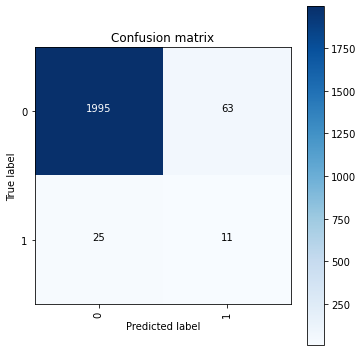

In [ ]:
from torchtext import legacy
import torch.optim as optim


for ifold in range(1,2):
  print('fold ', ifold)

  TEXT = legacy.data.Field(batch_first = True,
                    use_vocab = False,
                    tokenize = tokenize_and_cut,
                    preprocessing = bert_tokenizer.convert_tokens_to_ids,
                    init_token = init_token_idx,
                    eos_token = eos_token_idx,
                    pad_token = pad_token_idx,
                    unk_token = unk_token_idx)

  LABEL = legacy.data.LabelField()

  fields = [('text', TEXT),('label', LABEL)]

  train_data, valid_data, test_data = legacy.data.TabularDataset.splits(
                                          path = '.',
                                          train = 'train_'+str(ifold)+'.csv',
                                          validation = 'test_'+str(ifold)+'.csv',
                                          test = 'test_'+str(ifold)+'.csv',
                                          format = 'csv',
                                          fields = fields,
                                          skip_header = True)


  LABEL.build_vocab(train_data)

  train_iterator, valid_iterator, test_iterator = legacy.data.BucketIterator.splits(
      (train_data, valid_data, test_data), 
      sort = False,
      batch_size = BATCH_SIZE, 
      device = device)
  
  # bert = RobertaModel.from_pretrained('roberta-base')
  bert = BertModel.from_pretrained('bert-base-cased')
  model = Sentiment(bert,
                        HIDDEN_DIM,
                        OUTPUT_DIM,
                        N_LAYERS,
                        BIDIRECTIONAL,
                        DROPOUT)
  # model = PooledBiLSTM(bert)
  for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

  optimizer = optim.Adam(model.parameters()) #lr=0.005
  num_0 = sum([int(vars(train_data.examples[i])['label']) for i in range(len(train_data.examples))])
  ppot = [len(train_data.examples)-num_0, num_0]
  weight = torch.tensor([max(ppot)/ppot[0], max(ppot)/ppot[1]])
  criterion = nn.CrossEntropyLoss(weight=weight)
  model = model.to(device)
  criterion = criterion.to(device)

  best_valid_loss = float('inf')
  train_losses = []
  test_losses = []

  train_accs = []
  test_accs = []

  for epoch in range(N_EPOCHS):
      
      start_time = time.time()
      
      train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
      valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
          
      end_time = time.time()
          
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      train_losses.append(train_loss)
      test_losses.append(valid_loss)

      train_accs.append(train_acc)
      test_accs.append(valid_acc)
          
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'tut6-model.pt')
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  model.load_state_dict(torch.load('tut6-model.pt'))
  pp_bert = test_eval(model, test_iterator)


In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))
pp_bert = test_eval(model, test_iterator)

In [ ]:
pp_bert[0]

# RoBERTa Baseline for Task 1

In [ ]:
trdf1=pd.read_csv('train_1.csv')
trdf1.head()

,text,label
0,poor-families United Kingdom the scheme saw an...,1
1,homeless South Africa durban 's homeless commu...,0
2,poor-families Sri Lanka the next immediate pro...,0
3,vulnerable New Zealand far more important than...,1
4,poor-families Ghana to strengthen child-sensit...,1


In [ ]:
tedf1=pd.read_csv('test_1.csv')
tedf1.head()

,text,label
0,hopeless United States we also know that they ...,1
1,refugee Nigeria pope francis washed and kissed...,0
2,refugee Nigeria many refugees do n't want to b...,0
3,"in-need Ireland ""budding chefs , like """" fred ...",1
4,"homeless Pakistan ""in a 90-degree view of his ...",0


In [ ]:
# downsample negative instances
# pcldf = trdf1[trdf1.label==1]
pcldf = trdf1[trdf1['label'].eq(pd.Series([1 for i in range(len(trdf1))]))]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1['label'].eq(pd.Series([0 for i in range(len(trdf1))]))][:npos*2]])
# training_set1 = pd.concat([pcldf,trdf1[trdf1['label'].eq(pd.Series([0 for i in range(len(trdf1))]))].sample(frac=1)])

In [ ]:
# trdf1[trdf1['label'].eq(pd.Series([0 for i in range(len(trdf1))]))].sample(frac=1)

In [ ]:
training_set1

,text,label
0,poor-families United Kingdom the scheme saw an...,1
3,vulnerable New Zealand far more important than...,1
4,poor-families Ghana to strengthen child-sensit...,1
5,"homeless Canada today , homeless women are sti...",1
7,"hopeless Philippines ""lougene has this message...",1
...,...,...
4753,vulnerable Ireland palizija was one of a numbe...,0
4754,women South Africa today many of the women who...,0
4755,in-need Jamaica fake friends dem ... only chec...,0
4756,migrant Philippines despite its weak show of l...,0


In [ ]:

task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)
task1_model = ClassificationModel("roberta", 
                                  'roberta-base', 
                                  args = task1_model_args, 
                                  num_labels=2,
                                  weight=[1, 3], 
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set1[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/6939 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/868 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [ ]:
Counter(preds_task1)

Counter({0: 1952, 1: 142})

In [ ]:
_,rr=task1_model.predict(tedf1.text.tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [ ]:
res = []
ra = 0.3
ba = 0.7
pbirdmpn = []
for i, v in enumerate(r):
  pr = np.exp(v[1])/(np.exp(v[0])+np.exp(v[1]))
  pb = np.exp(rr[i][1])/(np.exp(rr[i][0])+np.exp(rr[i][1]))
  pbirdmpn.append(((pr*ra)+(pb*ba))/(ra+ba))
  if ((pr*ra)+(pb*ba))/(ra+ba) > 0.5:
    res.append(1)
  else:
    res.append(0)

In [ ]:
!mkdir res

mkdir: cannot create directory ‘res’: File exists


In [ ]:

!rm res/task1.txt
labels2file([[k] for k in (res)], os.path.join('res/', 'task1.txt'))

In [ ]:
# !mkdir res

In [ ]:
# labels2file([[k] for k in preds_task1], os.path.join('res/', 'task1.txt'))

In [ ]:
!rm -rf res
!mkdir res 
labels2file([[k] for k in (preds_task1)], os.path.join('res/', 'task1.txt'))
label_test = list(tedf1.label)
!rm -rf ref
!mkdir ref
labels2file([[i] for i in (label_test)], os.path.join('ref/', 'task1.txt'))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:

res = []
ra = 1
ba = 0
for i, v in enumerate(pbirdmpn):
  pr = v
  pb = np.exp(pp_bert[i][1])/(np.exp(pp_bert[i][0])+np.exp(pp_bert[i][1]))
  if ((pr*ra)+(pb*ba))/(ra+ba) > 0.5:
    res.append(1)
  else:
    res.append(0)

In [ ]:

!rm res/task1.txt
labels2file([[k] for k in (res)], os.path.join('res/', 'task1.txt'))

In [ ]:

task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)

# num_labels=4,
    # pos_weight=[1, 0.5, 1, 2]

task1_model = ClassificationModel("electra", 
                                  'google/electra-base-discriminator', 
                                  args = task1_model_args, 
                                  num_labels=2,
                                  # weight=[1, 3],
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set1[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/7338 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/918 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of electra model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [ ]:
!rm -rf res
!mkdir res 
labels2file([[k] for k in (preds_task1)], os.path.join('res/', 'task1.txt'))
label_test = list(tedf1.label)
!rm -rf ref
!mkdir ref
labels2file([[i] for i in (label_test)], os.path.join('ref/', 'task1.txt'))

In [ ]:

task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)

# num_labels=4,
    # pos_weight=[1, 0.5, 1, 2]

task1_model = ClassificationModel("bigbird", 
                                  'google/bigbird-roberta-base', 
                                  args = task1_model_args, 
                                  num_labels=2,
                                  weight=[1, 4],
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set1[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForSequenceClassifica

Downloading:   0%|          | 0.00/826k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/6849 [00:00<?, ?it/s]

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_cha

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/857 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 128 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...
INFO:simpletransformers.classification.classification_model: Training of bigbird model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


  0%|          | 0/262 [00:00<?, ?it/s]

In [ ]:
_,rb = task1_model.predict(tedf1.text.tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


  0%|          | 0/262 [00:00<?, ?it/s]

In [ ]:
!rm -rf res
!mkdir res 
labels2file([[k] for k in (preds_task1)], os.path.join('res/', 'task1.txt'))
label_test = list(tedf1.label)
!rm -rf ref
!mkdir ref
labels2file([[i] for i in (label_test)], os.path.join('ref/', 'task1.txt'))

In [ ]:

task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)

# num_labels=4,
    # pos_weight=[1, 0.5, 1, 2]

task1_model = ClassificationModel("mpnet", 
                                  'sentence-transformers/all-mpnet-base-v2', 
                                  args = task1_model_args, 
                                  num_labels=2,
                                  # weight=[1, 4],
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(training_set1[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at sentence-transformers/all-mpnet-base-v2 were not used when initializing MPNetForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/6849 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/857 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of mpnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

In [ ]:
_,r = task1_model.predict(tedf1.text.tolist())

In [ ]:
!rm -rf res
!mkdir res 
labels2file([[k] for k in (preds_task1)], os.path.join('res/', 'task1.txt'))
label_test = list(tedf1.label)
!rm -rf ref
!mkdir ref
labels2file([[i] for i in (label_test)], os.path.join('ref/', 'task1.txt'))

In [ ]:
res = []
ra = 0.5
ba = 0.5
pbirdmpn = []
for i, v in enumerate(r):
  pr = np.exp(v[1])/(np.exp(v[0])+np.exp(v[1]))
  pb = np.exp(rb[i][1])/(np.exp(rb[i][0])+np.exp(rb[i][1]))
  pbirdmpn.append(((pr*ra)+(pb*ba))/(ra+ba))
  if ((pr*ra)+(pb*ba))/(ra+ba) > 0.5:
    res.append(1)
  else:
    res.append(0)

In [ ]:
!rm res/task1.txt
labels2file([[k] for k in (res)], os.path.join('res/', 'task1.txt'))

In [ ]:
train_final = training_set1.copy(deep=True)
final_t = list(train_final['text'])
final_l = list(train_final['label'])

for i in list(tedf1[tedf1['label']==1]['text']):
  final_t.append(i)
  final_l.append(1)

train_final = pd.DataFrame({'text':[], 'label':[]})
train_final['text'] = final_t
train_final['label'] = final_l

In [ ]:
train_final.shape

(6887, 2)

In [ ]:
!wget https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv

--2022-01-23 16:43:49--  https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/TEST/task4_test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1145277 (1.1M) [text/plain]
Saving to: ‘task4_test.tsv’

task4_test.tsv      100%[===================>]   1.09M  --.-KB/s    in 0.07s   

2022-01-23 16:43:49 (15.7 MB/s) - ‘task4_test.tsv’ saved [1145277/1145277]



In [ ]:
test_final = pd.read_csv('task4_test.tsv', sep='\t', header=None)
test_final.shape

(3832, 5)

In [ ]:
def country_flag(df):
    # print(df[2])
    if (len(df[3])==2 and df[3].upper() in list_alpha_2):
        return pycountry.countries.get(alpha_2=df[3].upper()).name
    elif (len(df[3])==3 and df[3].upper() in list_alpha_3):
        return pycountry.countries.get(alpha_3=df[3].upper()).name
    else:
        return df[3]

In [ ]:
test_final[3] = test_final.apply(country_flag, axis = 1)
test_final.head()

,0,1,2,3,4
0,t_0,@@7258997,vulnerable,United States,"In the meantime , conservatives are working to..."
1,t_1,@@16397324,women,Pakistan,In most poor households with no education chil...
2,t_2,@@16257812,migrant,Canada,The real question is not whether immigration i...
3,t_3,@@3509652,migrant,United Kingdom,"In total , the country 's immigrant population..."
4,t_4,@@477506,vulnerable,Canada,"Members of the church , which is part of Ken C..."


In [ ]:
train_d = [str(test_final.iloc[i][2])+' '+str(test_final.iloc[i][3])+
           ' '+str(test_final.iloc[i][4]) for i in range(len(test_final))]

balance_train = train_d.copy()

temp_data = {'text': balance_train, 'label':[1 for i in range(len(balance_train))]}
test_final = pd.DataFrame.from_dict(temp_data)
test_final.head()

,text,label
0,"vulnerable United States In the meantime , con...",1
1,women Pakistan In most poor households with no...,1
2,migrant Canada The real question is not whethe...,1
3,"migrant United Kingdom In total , the country ...",1
4,"vulnerable Canada Members of the church , whic...",1


In [ ]:
train_final.to_csv('train_'+str(1)+'.csv', index=False)
test_final.to_csv('test_'+str(1)+'.csv', index=False)

In [ ]:


task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)

# num_labels=4,
    # pos_weight=[1, 0.5, 1, 2]

task1_model = ClassificationModel("bigbird", 
                                  'google/bigbird-roberta-base', 
                                  args = task1_model_args, 
                                  num_labels=2,
                                  weight=[1, 4],
                                  use_cuda=cuda_available)

# train model
task1_model.train_model(train_final[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(test_final.text.tolist())

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForSequenceClassifica

  0%|          | 0/6887 [00:00<?, ?it/s]

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_cha

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/861 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 128 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...
INFO:simpletransformers.classification.classification_model: Training of bigbird model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3832 [00:00<?, ?it/s]

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


  0%|          | 0/479 [00:00<?, ?it/s]

In [96]:
_,rr = task1_model.predict(test_final.text.tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3832 [00:00<?, ?it/s]

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


  0%|          | 0/479 [00:00<?, ?it/s]

In [97]:

task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)

# num_labels=4,
    # pos_weight=[1, 0.5, 1, 2]

task1_model = ClassificationModel("mpnet", 
                                  'sentence-transformers/all-mpnet-base-v2', 
                                  args = task1_model_args, 
                                  num_labels=2,
                                  # weight=[1, 3],
                                  use_cuda=cuda_available)
# train model
task1_model.train_model(train_final[['text', 'label']])
# run predictions
preds_task1, _ = task1_model.predict(test_final.text.tolist())

Some weights of the model checkpoint at sentence-transformers/all-mpnet-base-v2 were not used when initializing MPNetForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a

  0%|          | 0/6887 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/861 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of mpnet model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

In [98]:
_,r = task1_model.predict(test_final.text.tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/3832 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

In [99]:
res = []
ra = 0.5
ba = 0.5
pbirdmpn = []
for i, v in enumerate(r):
  pr = np.exp(v[1])/(np.exp(v[0])+np.exp(v[1]))
  pb = np.exp(rr[i][1])/(np.exp(rr[i][0])+np.exp(rr[i][1]))
  pbirdmpn.append(((pr*ra)+(pb*ba))/(ra+ba))
  if ((pr*ra)+(pb*ba))/(ra+ba) > 0.5:
    res.append(1)
  else:
    res.append(0)

In [100]:
!rm -rf res
!mkdir res
# !rm res/task1.txt
labels2file([[k] for k in (res)], os.path.join('res/', 'task1.txt')) 

# Rebuild training set (Task 2)

In [ ]:
lines = []

for i in range(1,8):
  with open('task1_'+str(i)+'.txt') as file:
      lines1 = file.readlines()
      lines1 = [line.rstrip() for line in lines1]
      lines.append(lines1)

In [ ]:
res = []
for i in range(len(lines1)):
  res.append([int(lines[j][i]) for j in range(7)])

labels2file(res, os.path.join('res/', 'task2.txt'))

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  label = trids.label[idx]
  # select row from original dataset to retrieve the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  rows2.append({
      'par_id':parid,
      'keyword':keyword,
      'country':country,
      'text':text,
      'label':label
  })
  

In [ ]:
trdf2 = pd.DataFrame(rows2)

In [ ]:
def country_flag(df):
    # print(df[2])
    if (len(df['country'])==2 and df['country'].upper() in list_alpha_2):
        return pycountry.countries.get(alpha_2=df['country'].upper()).name
    elif (len(df['country'])==3 and df['country'].upper() in list_alpha_3):
        return pycountry.countries.get(alpha_3=df['country'].upper()).name
    else:
        return df['country']

In [ ]:
trdf2['country']=trdf2.apply(country_flag, axis = 1)
trdf2.head()

,par_id,keyword,country,text,label
0,4341,poor-families,United Kingdom,"the scheme saw an estimated 150,000 children f...","[1, 0, 0, 1, 0, 0, 0]"
1,4136,homeless,South Africa,durban 's homeless communities reconciliation ...,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,poor-families,Sri Lanka,the next immediate problem that cropped up was...,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,vulnerable,New Zealand,far more important than the implications for t...,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,poor-families,Ghana,to strengthen child-sensitive social protectio...,"[1, 0, 0, 1, 1, 1, 0]"


In [ ]:
trdf2.label = trdf2.label.apply(literal_eval)

In [ ]:
trdf2.head()

,par_id,keyword,country,text,label
0,4341,poor-families,United Kingdom,"the scheme saw an estimated 150,000 children f...","[1, 0, 0, 1, 0, 0, 0]"
1,4136,homeless,South Africa,durban 's homeless communities reconciliation ...,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,poor-families,Sri Lanka,the next immediate problem that cropped up was...,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,vulnerable,New Zealand,far more important than the implications for t...,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,poor-families,Ghana,to strengthen child-sensitive social protectio...,"[1, 0, 0, 1, 1, 1, 0]"


# Rebuild test set (Task 2)

In [ ]:
rows2 = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  label = teids.label[idx]
  #print(parid)
  # select row from original dataset to access the `text` value
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  rows2.append({
      'par_id':parid,
      'keyword':keyword,
      'country':country,
      'text':text,
      'label':label
  })
  

In [ ]:
tedf2 = pd.DataFrame(rows2)

In [ ]:
tedf2['country']=tedf2.apply(country_flag, axis = 1)
tedf2.head()

,par_id,keyword,country,text,label
0,4046,hopeless,United States,we also know that they can benefit by receivin...,"[1, 0, 0, 1, 0, 0, 0]"
1,1279,refugee,Nigeria,pope francis washed and kissed the feet of mus...,"[0, 1, 0, 0, 0, 0, 0]"
2,8330,refugee,Nigeria,many refugees do n't want to be resettled anyw...,"[0, 0, 1, 0, 0, 0, 0]"
3,4063,in-need,Ireland,"""budding chefs , like """" fred """" , """" winston ...","[1, 0, 0, 1, 1, 1, 0]"
4,4089,homeless,Pakistan,"""in a 90-degree view of his constituency , one...","[1, 0, 0, 0, 0, 0, 0]"


In [ ]:
tedf2.label = tedf2.label.apply(literal_eval)

# Model t2

## EDA

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
import time
from transformers import BertTokenizer
import copy

# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased') #'bert-base-multilingual-cased'
# #bert-base-cased
# eos_token = bert_tokenizer.sep_token

# kfold = KFold(n_splits=10, shuffle=True, random_state=1234)
# enumerate the splits and summarize the distributions
ic = 1
# for train_ix, test_ix in kfold.split(range(len(task1))): #, task1['labels']
  # select rows
stt = time.time()
train, test = trdf2.copy(deep=True), tedf2.copy(deep=True)
# print(test)
train_d = [str(train.iloc[i]['keyword'])+' '+str(train.iloc[i]['country'])+' '+str(train.iloc[i]['text']) for i in range(len(train))]
# list(train['text'])
label = list(train['label'])

balance_train = train_d.copy()
balance_label = label.copy()

# for c in [0,2,3,5,6]:
#   ind = 0
#   dif = 510-cs[c]
#   while ind < dif:
#     i = np.random.choice(range(len(train_d)))
#     if label[i][c] == 1 and label[i][1] == 0 and label[i][4] == 0 :
#       if ind % 40 == 0:
#         balance_train.append(t.augment(train_d[i]))
#       else:
#         balance_train.append(t2.synonym_replacement(train_d[i]))
#       balance_label.append(copy.deepcopy(label[i]))
#       ind += 1

temp_data = {'text': balance_train, 'labels': balance_label}
bal_train = pd.DataFrame.from_dict(temp_data)
bal_train.to_csv('train_'+str(ic)+'.csv', index=False)
print(time.time()-stt)
train_d = [str(test.iloc[i]['keyword'])+' '+str(test.iloc[i]['country'])+' '+str(test.iloc[i]['text']) for i in range(len(test))]
# list(test['text'])
label = list(test['label'])

balance_train = train_d.copy()
balance_label = label.copy()

temp_data = {'text': balance_train, 'labels': balance_label}
bal_test = pd.DataFrame.from_dict(temp_data)
bal_test.to_csv('test_'+str(ic)+'.csv', index=False)
ic += 1

NameError: ignored

In [ ]:
def tokenize_and_cut(sentence):
    # print(sentence)
    # sentence = clean_doc(sentence)
    # sa, sb = sentence.split(eos_token)
    # sa = clean_doc(sa)
    # sb = clean_doc(sb)
    # print(sentence)
    # tokens = bert_tokenizer.tokenize(sentence)
    # tokens = bert_tokenizer(sa, sb, padding="max_length", truncation=True)
    tokens = bert_tokenizer(sentence, padding="max_length", truncation=True)
    # print(tokens) 
    # tokens = tokens[:max_input_length-2]
    return tokens['input_ids']

In [ ]:
import pandas as pd

sentence = list(pd.read_csv('test_1.csv')['text'])[0]
tokenize_and_cut(sentence)

NameError: ignored

In [ ]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from transformers import BertTokenizer, BertModel

# bert = BertModel.from_pretrained('bert-base-cased')
import torch.nn as nn

class Sentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        self.embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(self.embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(self.embedding_dim * 2, output_dim)
        self.out = nn.Linear(self.embedding_dim, output_dim)
        self.out = nn.Linear(2*hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]

        # print(text)
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]

        mean_span = []
        for i in range(embedded.size()[0]):
          sep_i = ((text[i] == 102).nonzero(as_tuple=True)[0][0])
          # print(sep_i)
          # print(embedded[i, 1:sep_i, :].size())
          mean_span.append(torch.mean(embedded[i, 1:sep_i, :], 0).reshape(1,-1))
        # print(tuple(mean_span))
        hidden = torch.cat(tuple(mean_span), 0)
        _, hidden = self.rnn(embedded)
        
        # hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        clss = embedded[:,0,:].reshape(-1, self.embedding_dim)

        # print(hidden.size(), clss.size())

        # hidden = torch.cat((hidden, clss), 1)
        # hidden = clss
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [ ]:
import torch.nn as nn

class PooledBiLSTM(nn.Module):
    
    def __init__(self,bert):
        super(PooledBiLSTM, self).__init__()
        self.hidden_size = 128
        drp = 0.1
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']

        self.lstm = nn.LSTM(embedding_dim, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*6 , self.hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(self.hidden_size, 7)


    def forward(self, text):
        with torch.no_grad():
            embedded = self.bert(text)[0]
        
        h_lstm, ht = self.lstm(embedded)
        hidden = ht[0]
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        # print(hidden.size())
        # print(avg_pool.size())
        # print(max_pool.size())
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = torch.cat(( conc, hidden), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 7
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    # return correct.sum() / torch.FloatTensor([y.shape[0]]).cuda()
    return correct.sum() / torch.FloatTensor([y.shape[0]]).item()

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    # for batch in iter(iterator):
    for i, data in enumerate(iterator, 0):
        # print(data['labels'])
        optimizer.zero_grad()

        inputs, labels = data['input_ids'], data['labels']
        inputs, labels = inputs.to(device), labels.to(device)
        
        predictions = model(inputs).squeeze(1)

        predictions = torch.sigmoid(predictions)

        loss = criterion(predictions, labels)
        
        # acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        # epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        # for batch in iterator:
        for i, data in enumerate(iterator, 0):

            inputs, labels = data['input_ids'], data['labels']
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs).squeeze(1)

            predictions = torch.sigmoid(predictions)
            
            loss = criterion(predictions, labels)
            
            # acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            # epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10

In [ ]:
!pip install pytorch-lightning==1.2.8 --quiet

In [ ]:
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(int(np.around([k])[0])) for k in pi])+'\n')

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import numpy as np


def test_eval(model, iterator):
    
    preds = []
    ys = []
    
    model.eval()
    
    with torch.no_grad():
    
        # for batch in iterator:
        for i, data in enumerate(iterator, 0):

            inputs, labels = data['input_ids'], data['labels']
            inputs, labels = inputs.to(device), labels.to(device)

            predictions = model(inputs).squeeze(1)
            predictions = torch.sigmoid(predictions)
            ys.append(labels.int())
            preds.append(predictions)
    
    y_preds = torch.cat(preds).cpu().numpy()
    label_test = torch.cat(ys).cpu().numpy()

    print(y_preds.shape)
    print(label_test.shape)

    
    # first, we need to create the res/ and ref/ folders which the evaluator expects
    !rm res/task2.txt
    # !mkdir ref res

    labels2file(y_preds, os.path.join('res/', 'task2.txt'))
    # labels2file(label_test, os.path.join('ref/', 'task2.txt'))

    !python3 evaluation.py . .

    
    # And get the results
    !cat scores.txt

    # THRESHOLD = 0.5
    # print(accuracy(label_test, y_preds, threshold=THRESHOLD))
    # print("AUROC per tag")
    # for i, name in enumerate(range(7)):
    #   tag_auroc = auroc(label_test[:, i], y_preds[:, i], pos_label=1)
    #   print(f"{name}: {tag_auroc}")
    # y_pred = label_test.numpy()
    # y_true = y_preds.numpy()

    # upper, lower = 1, 0

    # y_pred = np.where(y_pred > THRESHOLD, upper, lower)

    # print(classification_report(
    #   y_true, 
    #   y_pred, 
    #   target_names=range(7), 
    #   zero_division=0
    # ))


    # report = classification_report( label_test, y_preds )
    # print(report)
    # confusion_mtx = confusion_matrix(label_test, y_preds)
    # plot_confusion_matrix(confusion_mtx, range(len(set(label_test))), title='Confusion matrix')
    # print('f1', f1_score(label_test, y_preds, average='macro'))
    # print('precision', precision_score(label_test, y_preds, average='macro'))
    # print('recall', recall_score(label_test, y_preds, average='macro'))
    # print('accuracy', accuracy_score(label_test, y_preds))
    return

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 512
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.text
    labels = data_row['labels']

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      # comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      # attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
train_dataset = ToxicCommentsDataset(
  trdf2,
  bert_tokenizer,
  max_token_len=512
)

# sample_item = train_dataset[0]
# sample_item.keys()

In [ ]:
import pytorch_lightning as pl

class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=BATCH_SIZE, max_token_len=512):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
cs = {0: 230, 1: 716, 2: 196, 3: 224, 4: 469, 5: 197, 6: 40}

In [ ]:
from torchtext import legacy
import torch.optim as optim
import json


for ifold in range(1,2):
  print('fold ', ifold)

  # TEXT = legacy.data.Field(batch_first = True,
  #                   use_vocab = False,
  #                   tokenize = tokenize_and_cut)
  # LABEL = legacy.data.LabelField()

  # fields = [('text', TEXT),('label', LABEL)]

  # train_data, valid_data, test_data = legacy.data.TabularDataset.splits(
  #                                         path = '.',
  #                                         train = 'train_'+str(ifold)+'.csv',
  #                                         validation = 'test_'+str(ifold)+'.csv',
  #                                         test = 'test_'+str(ifold)+'.csv',
  #                                         format = 'csv',
  #                                         fields = fields,
  #                                         skip_header = True)


  # LABEL.build_vocab(train_data)
  # print(LABEL.vocab.stoi)

  # train_iterator, valid_iterator, test_iterator = legacy.data.BucketIterator.splits(
  #     (train_data, valid_data, test_data), 
  #     sort = False,
  #     batch_size = BATCH_SIZE, 
  #     device = device)
  train_df = pd.read_csv('train_'+str(ifold)+'.csv')
  val_df = pd.read_csv('test_'+str(ifold)+'.csv')

  def dese(df):
    return json.loads(df['labels'])

  train_df['labels'] = train_df.apply(dese, axis = 1)
  val_df['labels'] = val_df.apply(dese, axis = 1)

  data_module = ToxicCommentDataModule(
    train_df,
    val_df,
    bert_tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=512
  )

  data_module.setup()
  
  bert = BertModel.from_pretrained('bert-base-cased')
  model = Sentiment(bert,
                        HIDDEN_DIM,
                        OUTPUT_DIM,
                        N_LAYERS,
                        BIDIRECTIONAL,
                        DROPOUT)
  # model = PooledBiLSTM(bert)
  for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

  optimizer = optim.Adam(model.parameters()) #lr=0.005
  # num_0 = [LABEL.vocab.stoi[(vars(train_data.examples[i])['label'])] for i in range(len(train_data.examples))]
  # ppot = [num_0.count(i) for i in range(7)]
  # print(ppot)
  # weight = torch.tensor([max(ppot)/ppot[i] for i in range(7)])
  # criterion = nn.CrossEntropyLoss(weight=weight)
  # criterion = nn.CrossEntropyLoss()
  ws = []
  for i in cs.keys():
    ws.append(1/cs[i])
  # criterion = nn.BCELoss(weight=torch.FloatTensor(ws))
  criterion = nn.BCELoss()
  model = model.to(device)
  criterion = criterion.to(device)

  best_valid_loss = float('inf')
  train_losses = []
  test_losses = []

  train_accs = []
  test_accs = []

  for epoch in range(N_EPOCHS):
      
      start_time = time.time()
      
      train_loss, train_acc = train(model, data_module.train_dataloader(), optimizer, criterion)
      valid_loss, valid_acc = evaluate(model, data_module.val_dataloader(), criterion)
          
      end_time = time.time()
          
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      train_losses.append(train_loss)
      test_losses.append(valid_loss)

      train_accs.append(train_acc)
      test_accs.append(valid_acc)
          
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'tut6-model.pt')
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  model.load_state_dict(torch.load('tut6-model.pt'))
  test_eval(model, data_module.val_dataloader())

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))
test_eval(model, data_module.val_dataloader())

# RoBERTa baseline for Task 2

In [ ]:
trdf2 = pd.read_csv('train_1.csv')
tedf2 = pd.read_csv('test_1.csv')
tedf2.head()

,text,labels
0,hopeless United States we also know that they ...,"[1, 0, 0, 1, 0, 0, 0]"
1,refugee Nigeria pope francis washed and kissed...,"[0, 1, 0, 0, 0, 0, 0]"
2,refugee Nigeria many refugees do n't want to b...,"[0, 0, 1, 0, 0, 0, 0]"
3,"in-need Ireland ""budding chefs , like """" fred ...","[1, 0, 0, 1, 1, 1, 0]"
4,"homeless Pakistan ""in a 90-degree view of his ...","[1, 0, 0, 0, 0, 0, 0]"


In [ ]:
trdf2 = trdf2.rename(columns={"labels": "label"})
tedf2 = tedf2.rename(columns={"labels": "label"})

In [ ]:
trdf2.label = trdf2.label.apply(literal_eval)
tedf2.label = tedf2.label.apply(literal_eval)

In [ ]:
all_negs = trdf2[trdf2.label.apply(lambda x:sum(x) == 0)]
all_pos = trdf2[trdf2.label.apply(lambda x:sum(x) > 0)]

training_set2 = pd.concat([all_pos,all_negs[:round(len(all_pos)*0.5)]])

In [ ]:
training_set2

,text,label
0,poor-families United Kingdom the scheme saw an...,"[1, 0, 0, 1, 0, 0, 0]"
1,homeless South Africa durban 's homeless commu...,"[0, 1, 0, 0, 0, 0, 0]"
2,poor-families Sri Lanka the next immediate pro...,"[1, 0, 0, 0, 0, 1, 0]"
3,vulnerable New Zealand far more important than...,"[0, 0, 0, 1, 0, 0, 0]"
4,poor-families Ghana to strengthen child-sensit...,"[1, 0, 0, 1, 1, 1, 0]"
...,...,...
1186,"hopeless New Zealand """""" i was absolutely usel...","[0, 0, 0, 0, 0, 0, 0]"
1187,poor-families United States i also noticed the...,"[0, 0, 0, 0, 0, 0, 0]"
1188,hopeless Ghana can donald trump win ? it 's po...,"[0, 0, 0, 0, 0, 0, 0]"
1189,poor-families Singapore he added that any intr...,"[0, 0, 0, 0, 0, 0, 0]"


In [ ]:
task2_model_args = MultiLabelClassificationArgs(num_train_epochs=1,
                                                no_save=True, 
                                                no_cache=True, 
                                                overwrite_output_dir=True
                                                )
task2_model = MultiLabelClassificationModel("roberta", 
                                            'roberta-base', 
                                            num_labels=7,
                                            args = task2_model_args, 
                                            use_cuda=cuda_available)
# train model
task2_model.train_model(training_set2[['text', 'label']])
# run predictions
preds_task2, _ = task2_model.predict(tedf2.text.tolist())

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'c

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:586: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1191 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/149 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [ ]:
!mkdir res

In [ ]:
!rm res/task2.txt

rm: cannot remove 'res/task2.txt': No such file or directory


In [ ]:
labels2file(preds_task2, os.path.join('res/', 'task2.txt'))

## Prepare submission

In [ ]:
!cat res/task1.txt | head -n 10

1
1
0
1
1
1
1
1
1
1


In [ ]:
!cat res/task2.txt | head -n 10

1,0,0,0,0,0,0
1,0,0,0,0,0,0
0,0,0,0,0,0,0
1,0,0,0,0,0,0
0,0,0,0,0,0,0
0,0,0,0,0,1,0
1,0,0,0,0,0,0
1,0,0,0,0,0,0
0,0,0,0,0,0,0
1,0,0,0,0,1,0


In [ ]:
!zip submission.zip res/task1.txt res/task2.txt

updating: res/task1.txt (deflated 93%)
updating: res/task2.txt (deflated 97%)


In [ ]:
!mkdir ref

In [ ]:
import os
# for subtask 1 (we convert our list of labels into a list of lists to make 
# it compatible with the labels2file function)
# labels2file([[i] for i in list(tedf1.label)], os.path.join('ref/', 'task1.txt'))
# and for subtask 2
labels2file(list(tedf2.label), os.path.join('ref/', 'task2.txt'))

In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py


In [ ]:
# Now, we can just call the official scorer, which takes an input_directory and an output_directory
# as arguments. In this example, both will be the root directory of this notebook.
!python3 evaluation.py . .

In [ ]:
!zip submission.zip res/task1.txt 

updating: res/task1.txt (deflated 93%)
